<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/gage_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dataretrieval
import dataretrieval.nwis as nwis
import geopandas as gpd
from google.colab import drive
import pandas as pd
from shapely.geometry import box
from matplotlib import pyplot as plt

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nwis.get_info()

In [23]:
start = '2018-01-01'
end = '2024-12-31'
ne_gages = nwis.what_sites(stateCd='NE', siteType='ST', startDt=start, endDt=end, parameterCd='00060')
wy_gages = nwis.what_sites(stateCd='WY', siteType='ST', startDt=start, endDt=end, parameterCd='00060')
co_gages = nwis.what_sites(stateCd='CO', siteType='ST', startDt=start, endDt=end, parameterCd='00060')

<Axes: >

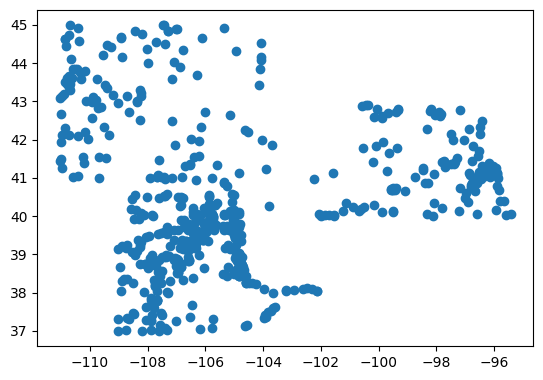

In [24]:
all_gages = pd.concat([ne_gages[0], wy_gages[0], co_gages[0]])
all_gages = gpd.GeoDataFrame(all_gages, geometry=all_gages.geometry)


In [8]:
vector_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp')


In [9]:
utm13 = box(-108, 0, -102, 90)
utm14 = box(-102, 0, -96, 90)
utm15 = box(-96, 0, -90, 90)

In [10]:
vcl_13 = vector_centerlines.clip(utm13).to_crs(32613)
vcl_14 = vector_centerlines.clip(utm14).to_crs(32614)
vcl_15 = vector_centerlines.clip(utm15).to_crs(32615)

In [11]:
buffer_13 = vcl_13\
    .set_geometry(vcl_13.buffer(50))\
    .dissolve()\
    .to_crs(4269)

buffer_14 = vcl_14.set_geometry(vcl_14.buffer(50))\
    .dissolve()\
    .to_crs(4269)

buffer_15 = vcl_15.set_geometry(vcl_15.buffer(50))\
    .dissolve()\
    .to_crs(4269)

In [12]:
large_buffer = pd.concat([buffer_13, buffer_14, buffer_15]).dissolve()

In [25]:
filtered_gages = all_gages.clip(large_buffer)

<Axes: >

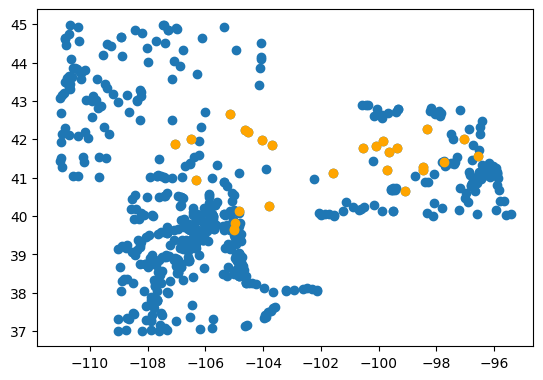

In [26]:
fig, ax = plt.subplots()
all_gages.plot(ax=ax)
filtered_gages.plot(ax=ax, color='orange')


In [15]:
gee_points = gpd.read_file('/content/drive/MyDrive/platte_points.shp')
gee_points_13 = gee_points.clip(utm13)\
    .to_crs(32613)

gee_points_14 = gee_points.clip(utm14)\
    .to_crs(32614)

gee_points_15 = gee_points.clip(utm15)\
    .to_crs(32615)


In [27]:
filtered_gages_13 = filtered_gages.clip(utm13)\
    .to_crs(32613)

filtered_gages_14 = filtered_gages.clip(utm14)\
    .to_crs(32614)

filtered_gages_15 = filtered_gages.clip(utm15)\
    .to_crs(32615)

In [28]:
nearest_pts_13 = gpd.sjoin_nearest(filtered_gages_13, gee_points_13)\
    .to_crs(4326)
nearest_pts_14 = gpd.sjoin_nearest(filtered_gages_14, gee_points_14)\
    .to_crs(4326)
nearest_pts_15 = gpd.sjoin_nearest(filtered_gages_15, gee_points_15)\
    .to_crs(4326)

nearest_pts = pd.concat([nearest_pts_15, nearest_pts_14, nearest_pts_13])

In [31]:
len(nearest_pts)

27

In [32]:
nearest_pts.to_csv('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.csv')